In [4]:
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import seaborn as sns
from scipy import stats
from itertools import chain
import shapely.vectorized as sv

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound

from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_statistic as ART_sta
from function import ART_downscale as ART_down

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


## BIAS CORRECTION USING MEVD MAPS - All Seeds

In [56]:
# product, time_reso, ncolor = 'IMERG', '1dy', 0
# product, time_reso, ncolor = 'CMORPH', '3h', 1
# product, time_reso, ncolor = 'MSWEP', '3h', 2
# product, time_reso, ncolor = 'ERA5', '3h', 3
# product, time_reso, ncolor = 'GSMaP', '3h', 4
# product, time_reso, ncolor = 'CHIRPS', '1dy', 5
product, time_reso, ncolor = 'ENSEMBLE_median', '1dy', 6

In [57]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'DEM','Italy_dem_800.geojson')) 
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [58]:
sat_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite')
dir_font = os.path.join('/')
obs_base = os.path.join(dir_font,'media','arturo','T9','Data','Italy','Rain_Gauges_QC')

In [59]:

def get_parameters(product, dir_base, val_max=1.1, corrected=False, corr_method=None):
    # The list bellow is the rain gauges with suspect data
    list_remove = [
            'IT-820_1424_FTS_1440_QCv4.csv', 'IT-250_602781_FTS_1440_QCv4.csv', 
            'IT-250_602779_FTS_1440_QCv4.csv', 'IT-780_2370_FTS_1440_QCv4.csv', 
            'IT-750_450_FTS_1440_QCv4.csv', 'IT-520_TOS11000099_FTS_1440_QCv4.csv',
            'IT-520_TOS11000080_FTS_1440_QCv4.csv', 'IT-520_TOS11000072_FTS_1440_QCv4.csv',
            'IT-520_TOS11000060_FTS_1440_QCv4.csv', 'IT-520_TOS11000025_FTS_1440_QCv4.csv',
            'IT-520_TOS09001200_FTS_1440_QCv4.csv', 'IT-520_TOS02000237_FTS_1440_QCv4.csv',
            'IT-230_1200_FTS_1440_QCv4.csv'
            ]

    if corrected == True:
        if corr_method == 'QQc':
            print(f"Loading {product} corrected statistics...")
            hdf5_file = os.path.join(dir_base,'statistics','QQc',f'statistics_obs_{product}_corrected_{corr_method}.h5')
        else:
            raise ValueError("corr_method must be specified between 'QQc' or 'LRC' when corrected=True")
    else:
        hdf5_file = os.path.join(dir_base,'statistics',f'statistics_obs_{product}.h5')
    data = pd.HDFStore(hdf5_file, mode='r')

    keys = data.keys()
    keys_QUANTILES = [k for k in keys if k.endswith("/QUANTILES")]
    keys_INFO = [k for k in keys if k.endswith('/INFO')]

    stations = []
    lats, lons, elevs = [], [], []
    Nobs, Cobs, Wobs = [], [], []
    OBS, MEVd = [], []
    for nn in range(len(keys_INFO)):
        station = keys_INFO[nn].split('/')[2]
        
        if station in list_remove:
            continue
        else:
            lat = data[keys_INFO[nn]]['lat_obs'].values[0]
            lon = data[keys_INFO[nn]]['lon_obs'].values[0]
            elev = data[keys_INFO[nn]]['elev_obs'].values[0]
            Obs_ = data[keys_QUANTILES[nn]].OBS.values[3]
            Down_ = data[keys_QUANTILES[nn]].SAT_down.values[3] 

            stations.append(station)
            lats.append(lat)
            lons.append(lon)
            elevs.append(elev)
            OBS.append(Obs_)
            MEVd.append(Down_)

    DF_DATA = pd.DataFrame({'STATION':stations, 'LON':lons, 'LAT':lats, 'ELEV':elevs, 'OBS':OBS, 'MEVd':MEVd})

    return DF_DATA

def Log_linear_test_ALL(OBS, SAT, SAT_ALL):
    obs_log = np.log1p(OBS)
    sat_log = np.log1p(SAT)

    mask = (~np.isnan(obs_log)) & (~np.isnan(sat_log))

    obs_log_clean = obs_log[mask]
    sat_log_clean = sat_log[mask]

    model = LinearRegression()
    model.fit(sat_log_clean.reshape(-1, 1), obs_log_clean)

    SAT_ALL_log = np.log1p(SAT_ALL.flatten())
    SAT_ALL_log_clear = SAT_ALL_log[~np.isnan(SAT_ALL_log)]

    sat_corr_log = model.predict(SAT_ALL_log_clear.reshape(-1, 1))
    sat_corrected = np.expm1(sat_corr_log)
    
    return sat_corrected

def Linear_Regression_2d(OBS, SAT, SAT_ALL):
    # 1. Crear el DataFrame
    df = pd.DataFrame({
        'OBS': OBS,
        'SAT': SAT
    })

    # (opcional pero recomendado) eliminar posibles NaN o inf
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # 2. Regresión lineal: SAT = slope * OBS + intercept
    result = linregress(df['OBS'], df['SAT'])

    slope = result.slope
    intercept = result.intercept
    
    # sat_corrected = slope * SAT_ALL  + intercept
    sat_corrected = (SAT_ALL  - intercept)/slope

    return sat_corrected

def Log_linear_test_ALL_no_intercept(OBS, SAT, SAT_ALL):
    log_obs = np.log(OBS)
    log_sat = np.log(SAT)

    # 1. Crear el DataFrame
    df = pd.DataFrame({
        'OBS': log_obs,
        'SAT': log_sat
    })

    # (opcional pero recomendado) eliminar posibles NaN o inf
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # 2. Regresión lineal: SAT = slope * OBS + intercept
    result = linregress(df['OBS'], df['SAT'])

    slope = result.slope
    intercept = result.intercept

    # Corrección: solo multiplicación por el slope
    SAT_ALL_log = np.log(SAT_ALL)
    sat_corr_log = (SAT_ALL_log - intercept)/slope
    sat_corrected = np.expm1(sat_corr_log)

    return sat_corrected

def CDFt(obs, sat_hist, sat_all):

    # --- Remove NaNs consistently (calibration only)
    mask = (~np.isnan(obs)) & (~np.isnan(sat_hist))
    obs = obs[mask]
    sat_hist = sat_hist[mask]

    obs_sorted = np.sort(obs)
    sat_sorted = np.sort(sat_hist)

    n = len(sat_sorted)
    p = (np.arange(1, n + 1) - 0.5) / n

    # --- Flatten sat_all
    sat_all_flat = sat_all.flatten()
    sat_corr_flat = np.full_like(sat_all_flat, np.nan, dtype=float)

    for i, x in enumerate(sat_all_flat):

        if np.isnan(x):
            continue

        q = np.interp(x, sat_sorted, p, left=p[0], right=p[-1])
        sat_corr_flat[i] = np.interp(q, p, obs_sorted)

    sat_corr_flat = np.maximum(sat_corr_flat, 0.0)

    # --- Reshape back
    sat_corr = sat_corr_flat.reshape(sat_all.shape)

    return sat_corr

def linear_regression(OBS, DOWN):
    
    OBS = np.array(OBS)
    DOWN = np.array(DOWN)

    mask = ~np.isnan(OBS) & ~np.isnan(DOWN)
    obs_clean = OBS[mask].reshape(-1, 1) 
    down_clean = DOWN[mask]

    reg = LinearRegression()
    reg.fit(obs_clean, down_clean)

    slope = reg.coef_[0]
    intercept = reg.intercept_

    x_line = np.linspace(np.min(obs_clean), np.max(obs_clean), 100).reshape(-1, 1)
    y_line = reg.predict(x_line)
    
    return slope, intercept, x_line, y_line

In [60]:
italy_geom = ITALY.union_all()

In [61]:
frac = 0.7
seeds_list = [7, 19, 31, 53, 89, 127, 211, 307, 401, 509, 613, 727, 839, 947, 1051]

for seed in seeds_list:
    print(f'Seed: {seed}')
    
    dir_ = os.path.join('/','media','arturo','T9','Data','Italy')
    if product == 'ENSEMBLE_median':
        DF_INPUT = get_parameters('ENSEMBLE_ALL_MEDIAN',dir_)
    else:
        DF_INPUT = get_parameters(product,dir_)
    
    METADATA = pd.read_csv(os.path.join(obs_base, 'data', 'METADATA', 'METADATA_FTS_QCv4_Case1_wAIRHO_v3_1dy.csv'))
    METADATA_CLEAR = METADATA[METADATA['File'].isin(DF_INPUT['STATION'])].reset_index(drop=True)

    Q_train_list = []
    Q_val_list = []

    for iso in METADATA_CLEAR['ISO'].unique():

        META_iso = METADATA_CLEAR[METADATA_CLEAR['ISO'] == iso]

        # Si una región tiene muy pocas estaciones, evita errores
        if len(META_iso) < 2:
            Q_train_list.append(META_iso)
            continue

        META_80 = META_iso.sample(frac=frac, random_state=seed)
        META_20 = META_iso.drop(META_80.index)

        Q_train_list.append(META_80)
        Q_val_list.append(META_20)

    Q_train = pd.concat(Q_train_list, ignore_index=True)
    Q_val = pd.concat(Q_val_list, ignore_index=True)
    list_train = Q_train.File.values
    
    DF_train = DF_INPUT[DF_INPUT['STATION'].isin(Q_train['File'])].reset_index(drop=True)

    pos = 3

    if product == 'ENSEMBLE_median':
        print('Ensemble')
        down_base = os.path.join(sat_base,'5_ENSEMBLE')
        filename = f'ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median.nc'
    else:
        down_base = os.path.join(sat_base,'5_DOWN')
        filename = f'ITALY_DOWN_{product}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc'

    dir_in = os.path.join(down_base, filename)

    DATA = xr.open_dataset(dir_in)
    Tr = int(DATA.Tr[pos].values)
    print(f'Return period: {Tr} years')

    lons, lats = DATA.lon.data, DATA.lat.data
    lon2dIM, lat2dIM = np.meshgrid(DATA.lon.data, DATA.lat.data)

    MEVd_IM = DATA.Mev_d

    mask_italy = sv.contains(italy_geom, lon2dIM, lat2dIM)
    MEVd_IM = MEVd_IM.where(mask_italy)
    MEVd_IM = MEVd_IM[pos,:,:].values

    original_shape = MEVd_IM.shape
    mask = ~np.isnan(MEVd_IM)
    
    # MEVd_IM_LLc_full = Log_linear_test_ALL(DF_train.OBS.values, DF_train.MEVd.values,MEVd_IM)
    # MEVd_IM_LLc_2d = np.full(original_shape, np.nan)
    # MEVd_IM_LLc_2d[mask] = MEVd_IM_LLc_full
    
    # MEVd_IM_LLc2_full = Log_linear_test_ALL_no_intercept(DF_train.OBS.values, DF_train.MEVd.values, MEVd_IM)
    # MEVd_IM_LLc2_2d = np.full(original_shape, np.nan)
    # MEVd_IM_LLc2_2d[mask] = MEVd_IM_LLc2_full
    
    MEVd_IM_LLc_2d = Linear_Regression_2d(DF_train.OBS.values, DF_train.MEVd.values, MEVd_IM)

    MEVd_IM_LSc_2d = Log_linear_test_ALL_no_intercept(DF_train.OBS.values, DF_train.MEVd.values, MEVd_IM)
    
    MEVd_IM_QQc_2d = CDFt(DF_train.OBS.values, DF_train.MEVd.values, MEVd_IM)
    
    DOWN_corrected = xr.Dataset(
        data_vars={
            "MEVd_Down": (("lat","lon"), MEVd_IM), 
            "MEVd_LLc": (("lat","lon"), MEVd_IM_LLc_2d),
            "MEVd_LSc": (("lat","lon"), MEVd_IM_LSc_2d),
            "MEVd_QQc": (("lat","lon"), MEVd_IM_QQc_2d),
            },
        coords={
            'lat': lats, 
            'lon': lons
            },
            attrs=dict(description=f"{product} Extreme quantiles corrected for {Tr} years, applying QQc and LLc method using 70% of stations in Italy",))

    DOWN_corrected.MEVd_Down.attrs["units"] = "mm/day"
    DOWN_corrected.MEVd_Down.attrs["long_name"] = "Downscaling Extreme quantiles"
    DOWN_corrected.MEVd_Down.attrs["origname"] = "Origial Downscaled"

    DOWN_corrected.MEVd_LLc.attrs["units"] = "mm/day"
    DOWN_corrected.MEVd_LLc.attrs["long_name"] = "Extreme quantiles corrected with LLc method"
    DOWN_corrected.MEVd_LLc.attrs["origname"] = "Linear Regresion log"

    DOWN_corrected.MEVd_LSc.attrs["units"] = "mm/day"
    DOWN_corrected.MEVd_LSc.attrs["long_name"] = "Extreme quantiles corrected with LLc method without using intercept"
    DOWN_corrected.MEVd_LSc.attrs["origname"] = "Linear Regresion log without intercept"

    DOWN_corrected.MEVd_QQc.attrs["units"] = "mm/day"
    DOWN_corrected.MEVd_QQc.attrs["long_name"] = "Extreme quantiles corrected with QQc method"
    DOWN_corrected.MEVd_QQc.attrs["origname"] = "Quantile-Quantile map"

    dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected','QUANTILE')
    if product == 'ENSEMBLE_median':
        nameout = (
                    dir_in.split('/')[-1]
                    .replace('_pearson', f'_pearson_QQc_LLc_{str(seed).zfill(4)}')
                    .replace('ENSEMBLE_ALL', 'DOWN_ENSEMBLE_median')
                    .replace('_median.nc', '.nc')
                    )
    else:
        nameout = dir_in.split('/')[-1].replace('_pearson',f'_pearson_QQc_LLc_{str(seed).zfill(4)}')

    PRE_out = os.path.join(os.path.join(dir_base, nameout))
    print(f'Exportin as: {PRE_out}')
    DOWN_corrected.to_netcdf(PRE_out)
    print()

Seed: 7
Ensemble
Return period: 50 years
Exportin as: /media/arturo/T9/Data/Italy/Satellite/6_DOWN_BCorrected/QUANTILE/ITALY_DOWN_ENSEMBLE_median_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_QQc_LLc_0007.nc

Seed: 19
Ensemble
Return period: 50 years
Exportin as: /media/arturo/T9/Data/Italy/Satellite/6_DOWN_BCorrected/QUANTILE/ITALY_DOWN_ENSEMBLE_median_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_QQc_LLc_0019.nc

Seed: 31
Ensemble
Return period: 50 years
Exportin as: /media/arturo/T9/Data/Italy/Satellite/6_DOWN_BCorrected/QUANTILE/ITALY_DOWN_ENSEMBLE_median_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_QQc_LLc_0031.nc

Seed: 53
Ensemble
Return period: 50 years
Exportin as: /media/arturo/T9/Data/Italy/Satellite/6_DOWN_BCorrected/QUANTILE/ITALY_DOWN_ENSEMBLE_median_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_QQc_LLc_0053.nc

Seed: 89
Ensemble
Return period: 50 years
Exportin as: /media/arturo/T9/Data/Italy/Satellite/6_DOWN_BCorrected/QUANTILE/ITALY_DOWN_ENSEMBLE_m

In [62]:
playsound("../sound/HOMER_DOH.mp3")

In [63]:
sys.exit()

SystemExit: 

## BIAS CORRECTION USING MEVD MAPS - Individual Seed

In [5]:
# product, time_reso, ncolor = 'IMERG', '1dy', 0
# product, time_reso, ncolor = 'CMORPH', '3h', 1
# product, time_reso, ncolor = 'MSWEP', '3h', 2
# product, time_reso, ncolor = 'ERA5', '3h', 3
# product, time_reso, ncolor = 'GSMaP', '3h', 4
# product, time_reso, ncolor = 'CHIRPS', '1dy', 5
product, time_reso, ncolor = 'ENSEMBLE_median', '1dy', 6

In [6]:
frac = 0.7
seeds_list = [7, 19, 31, 53, 89, 127, 211, 307, 401, 509, 613, 727, 839, 947, 1051]
seed = seeds_list[0]
print(f'Seed: {seed}')

Seed: 7


In [7]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'DEM','Italy_dem_800.geojson')) 
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [8]:
sat_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite')
dir_font = os.path.join('/')
obs_base = os.path.join(dir_font,'media','arturo','T9','Data','Italy','Rain_Gauges_QC')

In [9]:
italy_geom = ITALY.union_all()

In [95]:
def get_parameters(product, dir_base, val_max=1.1, corrected=False, corr_method=None):
    # The list bellow is the rain gauges with suspect data
    list_remove = [
            'IT-820_1424_FTS_1440_QCv4.csv', 'IT-250_602781_FTS_1440_QCv4.csv', 
            'IT-250_602779_FTS_1440_QCv4.csv', 'IT-780_2370_FTS_1440_QCv4.csv', 
            'IT-750_450_FTS_1440_QCv4.csv', 'IT-520_TOS11000099_FTS_1440_QCv4.csv',
            'IT-520_TOS11000080_FTS_1440_QCv4.csv', 'IT-520_TOS11000072_FTS_1440_QCv4.csv',
            'IT-520_TOS11000060_FTS_1440_QCv4.csv', 'IT-520_TOS11000025_FTS_1440_QCv4.csv',
            'IT-520_TOS09001200_FTS_1440_QCv4.csv', 'IT-520_TOS02000237_FTS_1440_QCv4.csv',
            'IT-230_1200_FTS_1440_QCv4.csv'
            ]

    if corrected == True:
        if corr_method == 'QQc':
            print(f"Loading {product} corrected statistics...")
            hdf5_file = os.path.join(dir_base,'statistics','QQc',f'statistics_obs_{product}_corrected_{corr_method}.h5')
        else:
            raise ValueError("corr_method must be specified between 'QQc' or 'LRC' when corrected=True")
    else:
        hdf5_file = os.path.join(dir_base,'statistics',f'statistics_obs_{product}.h5')
    data = pd.HDFStore(hdf5_file, mode='r')

    keys = data.keys()
    keys_QUANTILES = [k for k in keys if k.endswith("/QUANTILES")]
    keys_INFO = [k for k in keys if k.endswith('/INFO')]

    stations = []
    lats, lons, elevs = [], [], []
    Nobs, Cobs, Wobs = [], [], []
    OBS, MEVd = [], []
    for nn in range(len(keys_INFO)):
        station = keys_INFO[nn].split('/')[2]
        
        if station in list_remove:
            continue
        else:
            lat = data[keys_INFO[nn]]['lat_obs'].values[0]
            lon = data[keys_INFO[nn]]['lon_obs'].values[0]
            elev = data[keys_INFO[nn]]['elev_obs'].values[0]
            Obs_ = data[keys_QUANTILES[nn]].OBS.values[3]
            Down_ = data[keys_QUANTILES[nn]].SAT_down.values[3] 

            stations.append(station)
            lats.append(lat)
            lons.append(lon)
            elevs.append(elev)
            OBS.append(Obs_)
            MEVd.append(Down_)

    DF_DATA = pd.DataFrame({'STATION':stations, 'LON':lons, 'LAT':lats, 'ELEV':elevs, 'OBS':OBS, 'MEVd':MEVd})

    return DF_DATA

# =====================================================================================================================
# For test
def Linear_Regression_2d(OBS, SAT, SAT_ALL):
    # 1. Crear el DataFrame
    df = pd.DataFrame({
        'OBS': OBS,
        'SAT': SAT
    })

    # (opcional pero recomendado) eliminar posibles NaN o inf
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # 2. Regresión lineal: SAT = slope * OBS + intercept
    result = linregress(df['OBS'], df['SAT'])

    slope = result.slope
    intercept = result.intercept
    
    # sat_corrected = slope * SAT_ALL  + intercept
    sat_corrected = (SAT_ALL  - intercept)/slope
    # sat_corrected = (SAT_ALL)/slope
    print(slope)

    return sat_corrected


def linear_bias_correction_zero_intercept(OBS, SAT, SAT_ALL):
    df = pd.DataFrame({
        'OBS': OBS,
        'SAT': SAT
    })
    
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    obs = df.OBS.values
    sat = df.SAT.values

    # Safety check
    if np.sum(sat**2) == 0:
        raise ValueError("SAT series contains only zeros after NaN removal.")

    # Slope forced through origin
    # slope = np.sum(sat * obs) / np.sum(sat**2)
    slope = np.sum(sat * obs) / np.sum(obs**2)

    # Bias correction
    SAT_corrected = SAT_ALL / slope
    print(slope)

    return SAT_corrected

# =====================================================================================================================

def bias_correction_log_linear(obs, sat, SAT_ALL):
    """
    Corrección de sesgo usando regresión lineal en escala logarítmica.
    
    Parámetros:
    obs: array de datos observados (positivos)
    sat: array de datos satelitales (positivos, misma longitud que obs)
    SAT_ALL: array de datos a corregir (positivos)
    
    Retorna:
    array corregido en escala original
    """
    # Aplicar logaritmo a los datos
    log_obs = np.log(obs)
    log_sat = np.log(sat)
    
    mask = (~np.isnan(log_obs)) & (~np.isnan(log_sat))
    
    log_obs = log_obs[mask]
    log_sat = log_sat[mask]
    
    # Realizar regresión lineal en escala logarítmica
    slope, intercept, _, _, _ = stats.linregress(log_sat, log_obs)
    
    # Aplicar corrección en escala logarítmica
    log_data_to_correct = np.log1p(SAT_ALL.flatten())
    log_data_to_correct = log_data_to_correct[~np.isnan(log_data_to_correct)]
    
    log_corrected = slope * log_data_to_correct + intercept
    
    # Regresar a escala original
    corrected_data = np.exp(log_corrected)
    
    return corrected_data

def bias_correction_log_linear_v2(obs, sat, SAT_ALL):
    log_obs = np.log(obs)
    log_sat = np.log(sat)

    # 1. Crear el DataFrame
    df = pd.DataFrame({
        'OBS': log_obs,
        'SAT': log_sat
    })

    # (opcional pero recomendado) eliminar posibles NaN o inf
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # 2. Regresión lineal: SAT = slope * OBS + intercept
    result = linregress(df['OBS'], df['SAT'])

    slope = result.slope
    intercept = result.intercept
    
    log_data_to_correct = np.log1p(SAT_ALL.flatten())
    log_data_to_correct = log_data_to_correct[~np.isnan(log_data_to_correct)]
    log_corrected = slope * log_data_to_correct + intercept
    
    # Regresar a escala original
    corrected_data = np.exp(log_corrected)
    
    return corrected_data

def Log_linear_test_ALL_no_intercept(OBS, SAT, SAT_ALL):
    log_obs = np.log(OBS)
    log_sat = np.log(SAT)

    # 1. Crear el DataFrame
    df = pd.DataFrame({
        'OBS': log_obs,
        'SAT': log_sat
    })

    # (opcional pero recomendado) eliminar posibles NaN o inf
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # 2. Regresión lineal: SAT = slope * OBS + intercept
    result = linregress(df['OBS'], df['SAT'])

    slope = result.slope
    intercept = result.intercept

    # Corrección: solo multiplicación por el slope
    SAT_ALL_log = np.log(SAT_ALL)
    sat_corr_log = (SAT_ALL_log - intercept)/slope
    sat_corrected = np.expm1(sat_corr_log)

    return sat_corrected

def CDFt(obs, sat_hist, sat_all):

    # --- Remove NaNs consistently (calibration only)
    mask = (~np.isnan(obs)) & (~np.isnan(sat_hist))
    obs = obs[mask]
    sat_hist = sat_hist[mask]

    obs_sorted = np.sort(obs)
    sat_sorted = np.sort(sat_hist)

    n = len(sat_sorted)
    p = (np.arange(1, n + 1) - 0.5) / n

    # --- Flatten sat_all
    sat_all_flat = sat_all.flatten()
    sat_corr_flat = np.full_like(sat_all_flat, np.nan, dtype=float)

    for i, x in enumerate(sat_all_flat):

        if np.isnan(x):
            continue

        q = np.interp(x, sat_sorted, p, left=p[0], right=p[-1])
        sat_corr_flat[i] = np.interp(q, p, obs_sorted)

    sat_corr_flat = np.maximum(sat_corr_flat, 0.0)

    # --- Reshape back
    sat_corr = sat_corr_flat.reshape(sat_all.shape)

    return sat_corr

def linear_regression(OBS, DOWN):
    
    OBS = np.array(OBS)
    DOWN = np.array(DOWN)

    mask = ~np.isnan(OBS) & ~np.isnan(DOWN)
    obs_clean = OBS[mask].reshape(-1, 1) 
    down_clean = DOWN[mask]

    reg = LinearRegression()
    reg.fit(obs_clean, down_clean)

    slope = reg.coef_[0]
    intercept = reg.intercept_

    x_line = np.linspace(np.min(obs_clean), np.max(obs_clean), 100).reshape(-1, 1)
    y_line = reg.predict(x_line)
    
    return slope, intercept, x_line, y_line

In [96]:
dir_ = os.path.join('/','media','arturo','T9','Data','Italy')
if product == 'ENSEMBLE_median':
    DF_INPUT = get_parameters('ENSEMBLE_ALL_MEDIAN',dir_)
else:
    DF_INPUT = get_parameters(product,dir_)

In [97]:
METADATA = pd.read_csv(os.path.join(obs_base, 'data', 'METADATA', 'METADATA_FTS_QCv4_Case1_wAIRHO_v3_1dy.csv'))
METADATA_CLEAR = METADATA[METADATA['File'].isin(DF_INPUT['STATION'])].reset_index(drop=True)

Q_train_list = []
Q_val_list = []

for iso in METADATA_CLEAR['ISO'].unique():

    META_iso = METADATA_CLEAR[METADATA_CLEAR['ISO'] == iso]

    # Si una región tiene muy pocas estaciones, evita errores
    if len(META_iso) < 2:
        Q_train_list.append(META_iso)
        continue

    META_80 = META_iso.sample(frac=frac, random_state=seed)
    META_20 = META_iso.drop(META_80.index)

    Q_train_list.append(META_80)
    Q_val_list.append(META_20)

Q_train = pd.concat(Q_train_list, ignore_index=True)
Q_val = pd.concat(Q_val_list, ignore_index=True)
list_train = Q_train.File.values

DF_train = DF_INPUT[DF_INPUT['STATION'].isin(Q_train['File'])].reset_index(drop=True)

In [98]:
pos = 3

if product == 'ENSEMBLE_median':
    print('Ensemble')
    down_base = os.path.join(sat_base,'5_ENSEMBLE')
    filename = f'ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median.nc'
else:
    down_base = os.path.join(sat_base,'5_DOWN')
    filename = f'ITALY_DOWN_{product}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc'

dir_in = os.path.join(down_base, filename)

DATA = xr.open_dataset(dir_in)
Tr = int(DATA.Tr[pos].values)
print(f'Return period: {Tr} years')

lons, lats = DATA.lon.data, DATA.lat.data
lon2dIM, lat2dIM = np.meshgrid(DATA.lon.data, DATA.lat.data)

MEVd_IM = DATA.Mev_d

mask_italy = sv.contains(italy_geom, lon2dIM, lat2dIM)
MEVd_IM = MEVd_IM.where(mask_italy)
MEVd_IM = MEVd_IM[pos,:,:].values

Ensemble
Return period: 50 years


In [99]:
original_shape = MEVd_IM.shape
mask = ~np.isnan(MEVd_IM)

# CORRECTION
# MEVd_IM_LLc_2d = Linear_Regression_2d(DF_train.OBS.values, DF_train.MEVd.values, MEVd_IM)
MEVd_IM_LLc_2d = Linear_Regression_2d(DF_train.OBS.values, DF_train.MEVd.values, MEVd_IM)

# MEVd_IM_LSc_2d = Log_linear_test_ALL_no_intercept(DF_train.OBS.values, DF_train.MEVd.values, MEVd_IM)
MEVd_IM_LSc_2d = linear_bias_correction_zero_intercept(DF_train.OBS.values, DF_train.MEVd.values, MEVd_IM)


MEVd_IM_QQc_2d = CDFt(DF_train.OBS.values, DF_train.MEVd.values, MEVd_IM)

0.24012604853603473
0.6093427345275841


In [100]:
DOWN_corrected = xr.Dataset(
    data_vars={
        "MEVd_Down": (("lat","lon"), MEVd_IM), 
        "MEVd_LLc": (("lat","lon"), MEVd_IM_LLc_2d),
        "MEVd_LSc": (("lat","lon"), MEVd_IM_LSc_2d),
        "MEVd_QQc": (("lat","lon"), MEVd_IM_QQc_2d),
        },
    coords={
        'lat': lats, 
        'lon': lons
        },
        attrs=dict(description=f"{product} Extreme quantiles corrected for {Tr} years, applying QQc and LLc method using 70% of stations in Italy",))

DOWN_corrected.MEVd_Down.attrs["units"] = "mm/day"
DOWN_corrected.MEVd_Down.attrs["long_name"] = "Downscaling Extreme quantiles"
DOWN_corrected.MEVd_Down.attrs["origname"] = "Origial Downscaled"

DOWN_corrected.MEVd_LLc.attrs["units"] = "mm/day"
DOWN_corrected.MEVd_LLc.attrs["long_name"] = "Extreme quantiles corrected with LLc method"
DOWN_corrected.MEVd_LLc.attrs["origname"] = "Linear Regresion log"

DOWN_corrected.MEVd_LSc.attrs["units"] = "mm/day"
DOWN_corrected.MEVd_LSc.attrs["long_name"] = "Extreme quantiles corrected with LLc method withour intercept"
DOWN_corrected.MEVd_LSc.attrs["origname"] = "Linear Regresion log without intercept"

DOWN_corrected.MEVd_QQc.attrs["units"] = "mm/day"
DOWN_corrected.MEVd_QQc.attrs["long_name"] = "Extreme quantiles corrected with QQc method"
DOWN_corrected.MEVd_QQc.attrs["origname"] = "Quantile-Quantile map"

dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected','QUANTILE')
PRE_out = os.path.join(os.path.join(dir_base, dir_in.split('/')[-1].replace('_pearson',f'_pearson_QQc_LLc_{str(seed).zfill(4)}')))
print(f'Exportin as: {PRE_out}')
# DOWN_corrected.to_netcdf(PRE_out)

Exportin as: /media/arturo/T9/Data/Italy/Satellite/6_DOWN_BCorrected/QUANTILE/ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_QQc_LLc_0007_median.nc


## Quickly Validation

In [101]:
DF_val = DF_INPUT[DF_INPUT['STATION'].isin(Q_val['File'])].reset_index(drop=True)
lats_obs = DF_val['LAT'].values
lons_obs = DF_val['LON'].values

In [102]:
MEV_QQc_vals, MEV_LSc_vals, MEV_LLc_vals = [], [], []

for lat, lon in zip(DF_val['LAT'].values, DF_val['LON'].values):
    ilat = np.argmin(np.abs(lats - lat))
    ilon = np.argmin(np.abs(lons - lon))
    MEV_LLc_vals.append(MEVd_IM_LLc_2d[ilat, ilon])
    MEV_LSc_vals.append(MEVd_IM_LSc_2d[ilat, ilon])
    MEV_QQc_vals.append(MEVd_IM_QQc_2d[ilat, ilon])

MEV_LLc_vals = np.array(MEV_LLc_vals)
MEV_LSc_vals = np.array(MEV_LSc_vals)
MEV_QQc_vals = np.array(MEV_QQc_vals)

DF_val['MEVd_LLc'] = MEV_LLc_vals
DF_val['MEVd_LSc'] = MEV_LSc_vals
DF_val['MEVd_QQc'] = MEV_QQc_vals

In [103]:
RE = (DF_val.MEVd.values - DF_val.OBS.values)/DF_val.OBS.values
RE_LLc = (DF_val.MEVd_LLc.values - DF_val.OBS.values)/DF_val.OBS.values
RE_LSc = (DF_val.MEVd_LSc.values - DF_val.OBS.values)/DF_val.OBS.values
RE_QQc = (DF_val.MEVd_QQc.values - DF_val.OBS.values)/DF_val.OBS.values

In [104]:
DF_val['RE'] = RE
DF_val['RE_LLc'] = RE_LLc
DF_val['RE_LSc'] = RE_LSc
DF_val['RE_QQc'] = RE_QQc

In [105]:
DF_val.head(3)

,STATION,LON,LAT,ELEV,OBS,MEVd,MEVd_LLc,MEVd_LSc,MEVd_QQc,RE,RE_LLc,RE_LSc,RE_QQc
0,IT-880_35807_FTS_1440_QCv4.csv,8.965278,39.157227,159.336197,181.723288,80.820457,43.363846,137.032366,95.444926,-0.555255,-0.761374,-0.245928,-0.474779
1,IT-880_35540_FTS_1440_QCv4.csv,9.411671,40.109446,1209.157959,219.866846,120.080193,193.846583,196.333680,171.011000,-0.453850,-0.118346,-0.107034,-0.222207
2,IT-880_35515_FTS_1440_QCv4.csv,9.513059,39.795554,573.283875,211.849633,102.278249,137.119783,173.979130,142.180422,-0.517213,-0.352749,-0.178761,-0.328862


In [106]:
colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange', 'cyan']

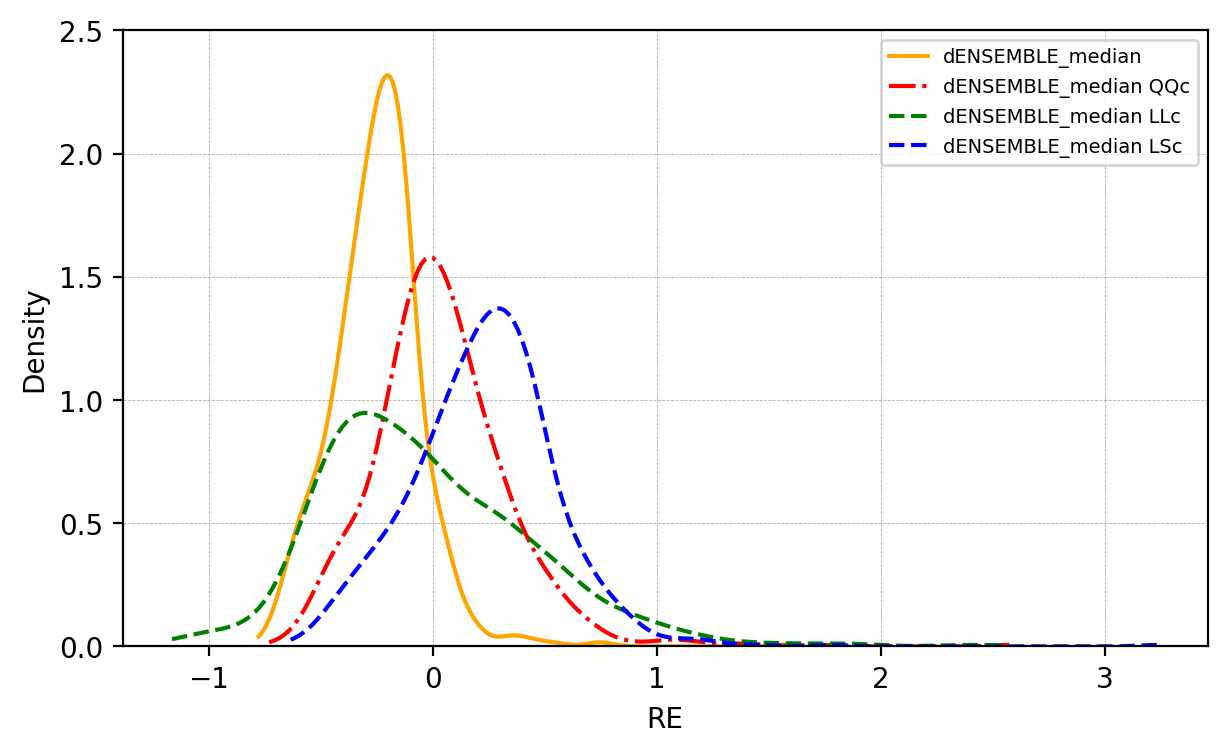

In [107]:
fig = plt.figure(figsize=(7,4),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(DF_val.RE,color=colors[ncolor],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'd{product}',
            clip=(np.nanmin(np.array(DF_val.RE)), np.nanmax(np.array(DF_val.RE))))
sns.kdeplot(DF_val.RE_QQc,color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'd{product} QQc',linestyle='-.',
            clip=(np.nanmin(np.array(DF_val.RE_QQc)), np.nanmax(np.array(DF_val.RE_QQc))))
sns.kdeplot(DF_val.RE_LLc,color='g',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'd{product} LLc',linestyle='--',
            clip=(np.nanmin(np.array(DF_val.RE_LLc)), np.nanmax(np.array(DF_val.RE_LLc))))
sns.kdeplot(DF_val.RE_LSc,color='b',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'd{product} LSc',linestyle='--',
            clip=(np.nanmin(np.array(DF_val.RE_LSc)), np.nanmax(np.array(DF_val.RE_LSc))))
# ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [108]:
_, _, x_OBS, y_OBS = linear_regression(DF_val.OBS, DF_val.MEVd)
_, _, x_LLc, y_LLc = linear_regression(DF_val.OBS, DF_val.MEVd_LLc)
_, _, x_LSc, y_LSc = linear_regression(DF_val.OBS, DF_val.MEVd_LSc)
_, _, x_QQc, y_QQc = linear_regression(DF_val.OBS, DF_val.MEVd_QQc)

Text(0.0, 1.0, '(b) dENSEMBLE_median - LSc')

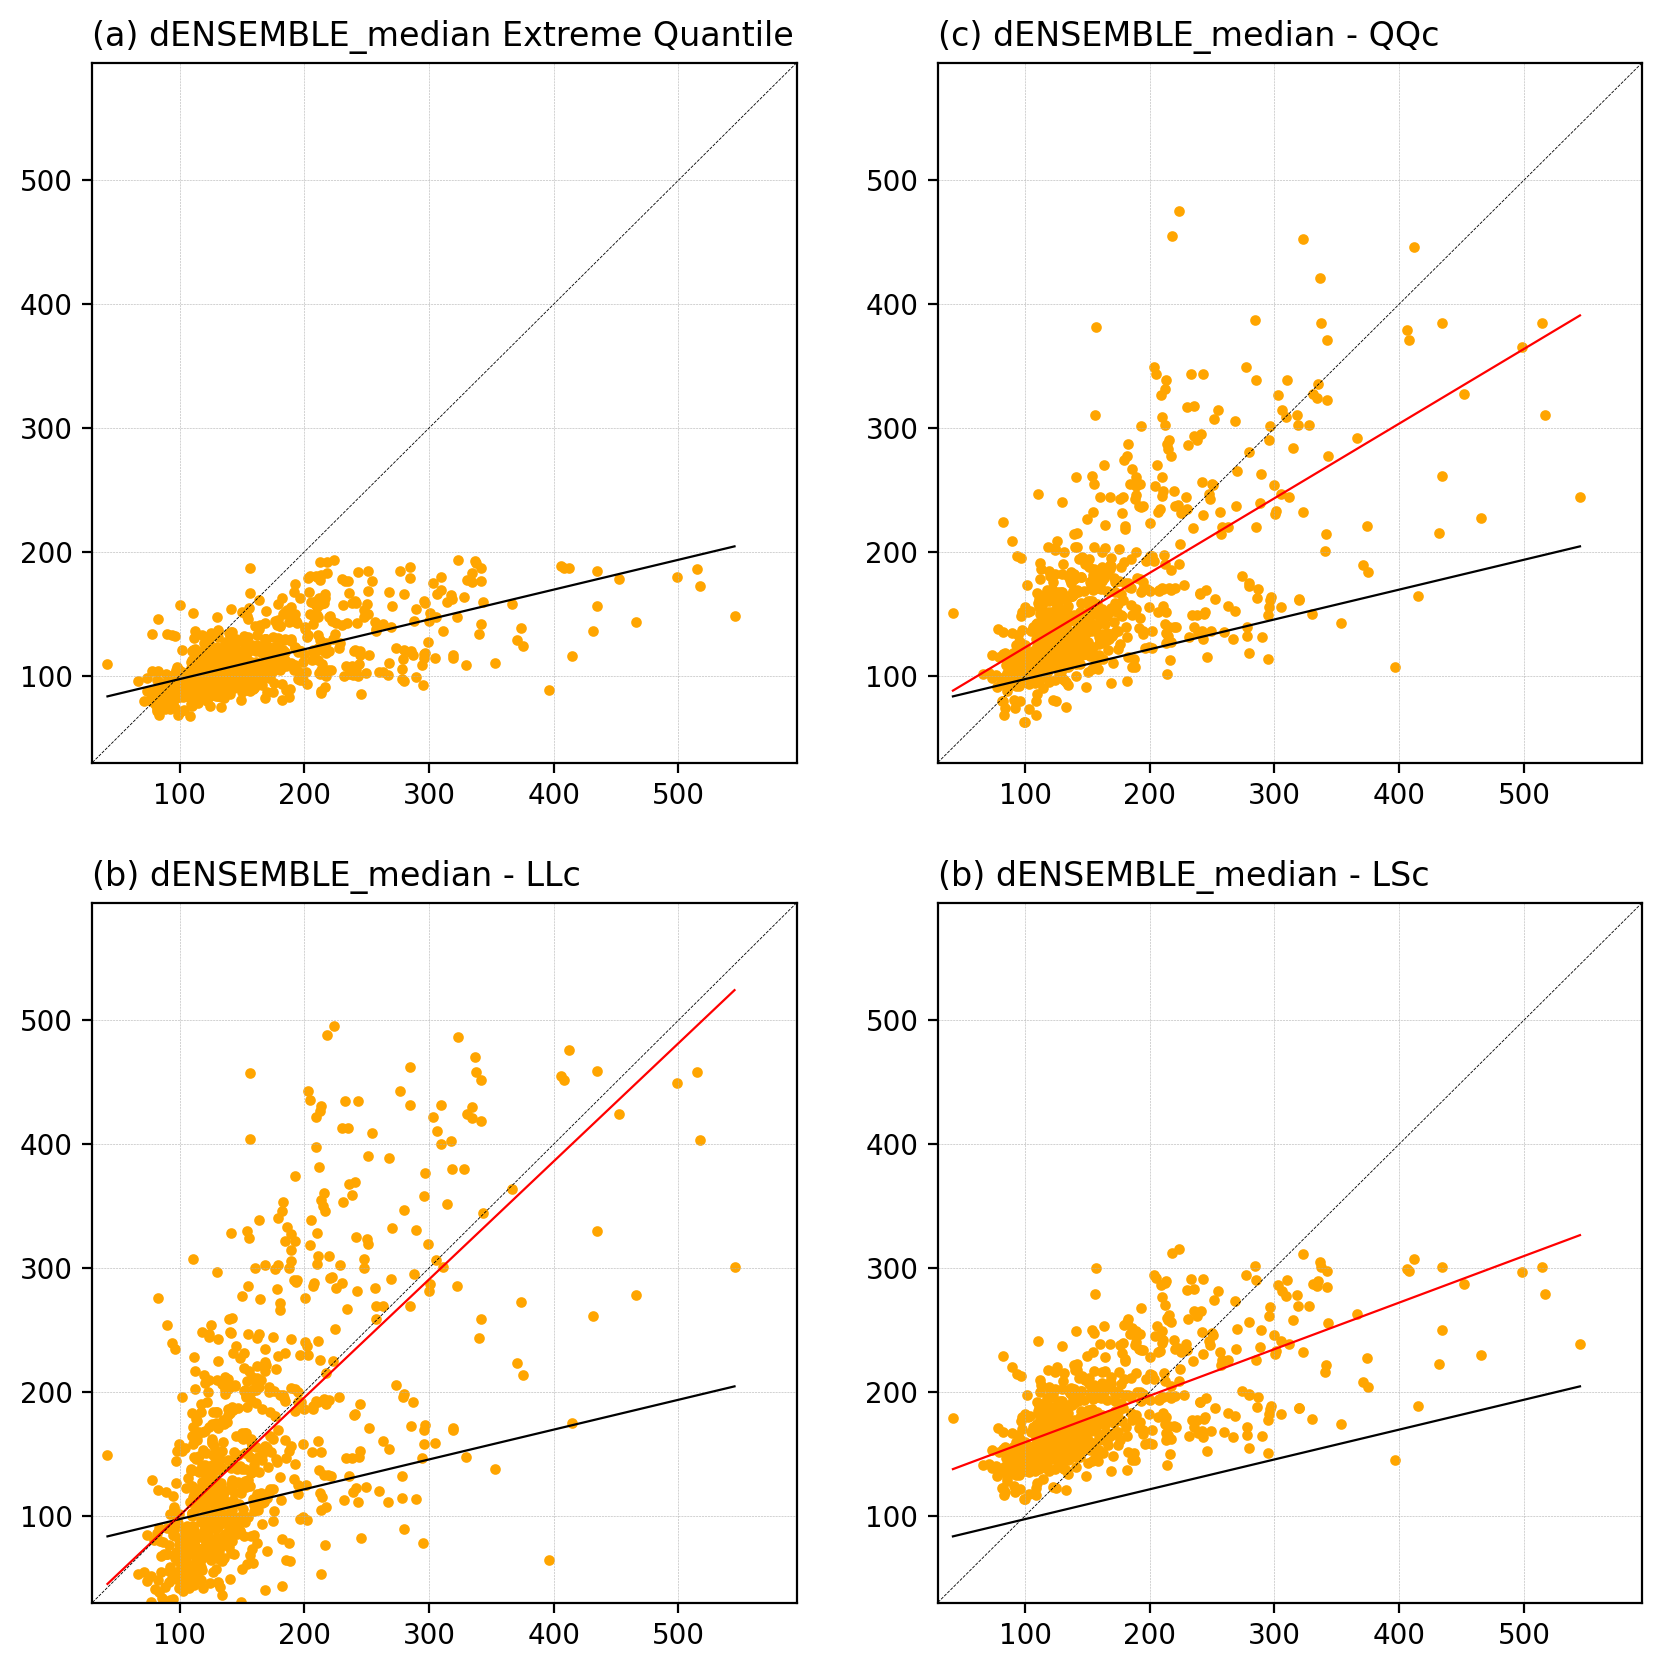

In [109]:
vmin = DF_val.OBS.min()
vmax = DF_val.OBS.max()

fig = plt.figure(figsize=(10,10),dpi=200)
gs = gridspec.GridSpec(2,2)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

ax1.scatter(DF_val.OBS, DF_val.MEVd, s=8, color=colors[ncolor], vmin=vmin, vmax=vmax)
ax1.plot(x_OBS, y_OBS, c='k',linewidth=0.8)
ax1.plot(np.arange(600),np.arange(600),'--k', linewidth=0.3, label='Identity line')
ax1.set_xlim(30,vmax+50)
ax1.set_ylim(30,vmax+50)
ax1.grid(linestyle='--', linewidth=0.2)
ax1.set_title(f'(a) d{product} Extreme Quantile ', fontsize=12, loc='left')

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1])

ax1.scatter(DF_val.OBS, DF_val.MEVd_QQc, s=8, color=colors[ncolor], vmin=vmin, vmax=vmax,)
ax1.plot(x_OBS, y_OBS, c='k',linewidth=0.8)
ax1.plot(x_QQc, y_QQc, c='r',linewidth=0.8)
ax1.plot(np.arange(600),np.arange(600),'--k', linewidth=0.3, label='Identity line')
ax1.set_xlim(30,vmax+50)
ax1.set_ylim(30,vmax+50)
ax1.grid(linestyle='--', linewidth=0.2)
ax1.set_title(f'(c) d{product} - QQc', fontsize=12, loc='left')

# =========================================================================================================================
ax1 = plt.subplot(gs[1, 0])

ax1.scatter(DF_val.OBS, DF_val.MEVd_LLc, s=8, color=colors[ncolor], vmin=vmin, vmax=vmax,)
ax1.plot(x_OBS, y_OBS, c='k',linewidth=0.8)
ax1.plot(x_LLc, y_LLc, c='r',linewidth=0.8)
ax1.plot(np.arange(600),np.arange(600),'--k', linewidth=0.3, label='Identity line')
ax1.set_xlim(30,vmax+50)
ax1.set_ylim(30,vmax+50)
ax1.grid(linestyle='--', linewidth=0.2)
ax1.set_title(f'(b) d{product} - LLc', fontsize=12, loc='left')

# =========================================================================================================================
ax1 = plt.subplot(gs[1, 1])

ax1.scatter(DF_val.OBS, DF_val.MEVd_LSc, s=8, color=colors[ncolor], vmin=vmin, vmax=vmax,)
ax1.plot(x_OBS, y_OBS, c='k',linewidth=0.8)
ax1.plot(x_LSc, y_LSc, c='r',linewidth=0.8)
ax1.plot(np.arange(600),np.arange(600),'--k', linewidth=0.3, label='Identity line')
ax1.set_xlim(30,vmax+50)
ax1.set_ylim(30,vmax+50)
ax1.grid(linestyle='--', linewidth=0.2)
ax1.set_title(f'(b) d{product} - LSc', fontsize=12, loc='left')
